#DERIVATIVES CREDIT RISK PROJECT

Authors: Federico La Penna, Tommaso Zazzaron, Joan Matons Framis, Michele Sacerdoti, Leon Khishba, Valeriano Palmieri

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.interpolate import interp1d

#Exercise 1: Hull-White and Numeraire simulation

In [8]:
#function Hull-White process
def HW(n, m, r0, theta , alpha,  sigma, dt, T):
    r = np.zeros(shape=(n,m+1))
    r[:,0] = r0
    for i in range(int(n)):
        for j in range(int(m)):
            r[i,j+1] = r[i,j] + (theta[j]- alpha * r[i,j])*dt +sigma * np.sqrt(dt)*np.random.normal(0,1)
    return r

In [9]:
#function numeraire
def numeraire(r, dt, include_T=True):
    delta = r[:, :-1] * dt
    total_integral = delta.sum(axis=1, keepdims=True)
    left_integral = np.cumsum(delta, axis=1)
    integral = total_integral - left_integral
    N = np.exp(- integral)
    if include_T:
        ones = np.ones((N.shape[0], 1))
        N = np.hstack([N, ones])
    return N

The process has the following SDE, with initial condition r0:
$$
dr(t) \;=\; \bigl(\theta(t) \;-\; a_{d}\,r_{d}(t)\bigr)\,dt \;+\; \sigma_{d}\,dW_{d}(t)
$$
The simulation has been implemented under the Euler-Maruyama discretization of the SDE. The following holds:
$$
r(t+\Delta t) \;=r(t) +\;\bigl(\theta(t) \;-\; a\,r(t)\bigr)\,Δt \;+\; \sigma\, \sqrt{\Delta t}\cdot N(0,1)
$$
The numeraire simulation instead takes as input the r(t) simulation. The following holds:
$$
numeraire = e^{-\int_t^Tr(s)ds}
$$The implementation has been done by the discretization of the integral.

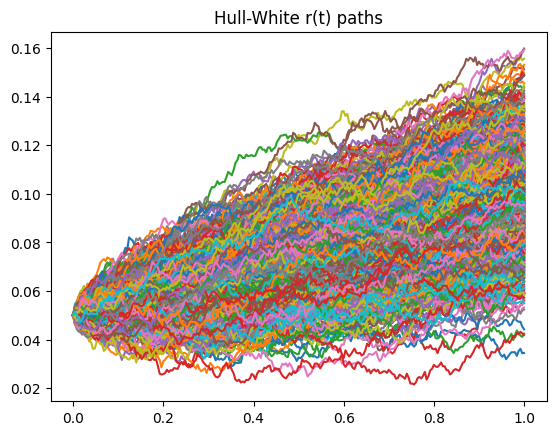

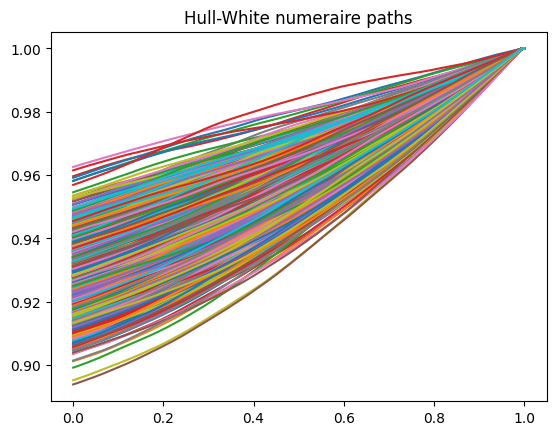

In [10]:
#EXAMPLE

T = 1
m = 250
dt= T/m
Nsim= 1000

r0= 0.05
alpha = 0.01
sigma = 0.02
theta = np.full(shape=(m,), fill_value=0.05)

r = HW(Nsim, m, r0, theta , alpha,  sigma, dt, T)
num = numeraire(r, dt)
ts = np.linspace(0,T,m+1)

for i in range(int(Nsim)):
  plt.plot(ts,r[i,:])
plt.title('Hull-White r(t) paths');
plt.show()

for i in range(int(Nsim)):
  plt.plot(ts,num[i,:])
plt.title('Hull-White numeraire paths');
plt.show()

#Exercise 2: Replication of today's ZCB curve

0.0017710955878040685


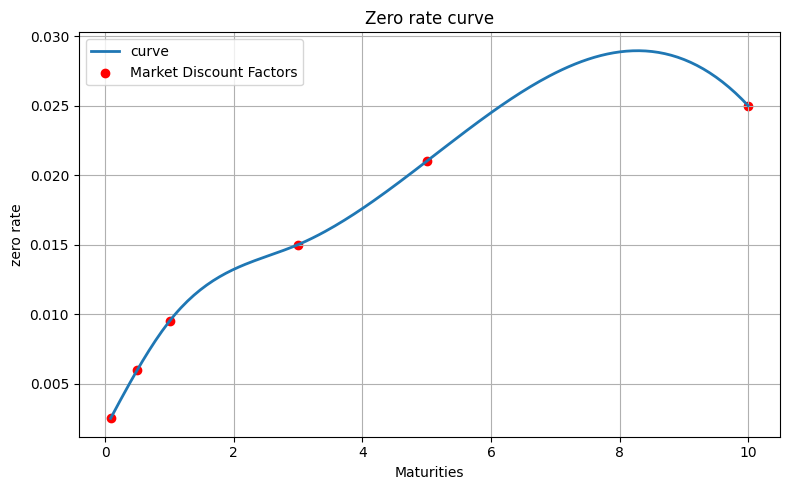

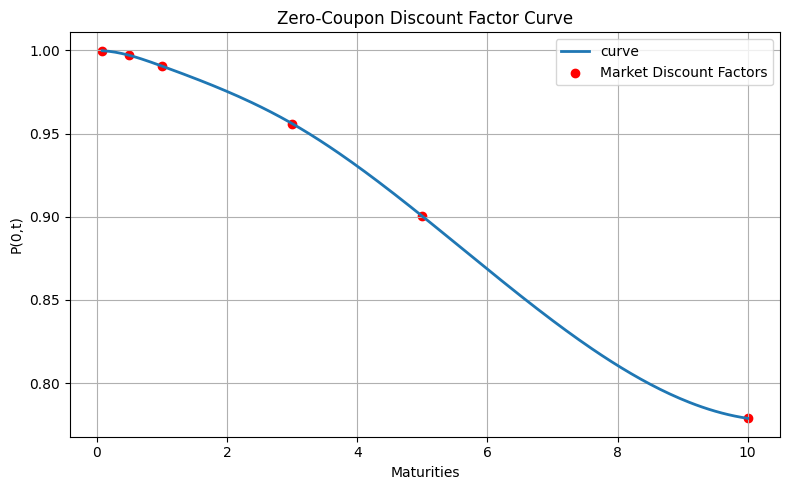

In [11]:
#Today zero curve
maturities = np.array([1/12, 0.5, 1, 3, 5, 10])
zero_rates  = np.array([0.25, 0.6, 0.95, 1.5, 2.1, 2.5]) / 100.0
ZCB_real_price = np.exp(-zero_rates * maturities)
P_curve = interp1d(maturities, ZCB_real_price, kind='cubic', fill_value='extrapolate')
t_grid = np.linspace(maturities.min(), maturities.max(), 200)
z_c = interp1d(maturities, zero_rates, kind='cubic', fill_value='extrapolate')

print(z_c(0))

plt.figure(figsize=(8, 5))
plt.plot(t_grid, z_c(t_grid), label='curve', linewidth=2)
plt.scatter(maturities, zero_rates, color='red', marker='o', label='Market Discount Factors')
plt.title('Zero rate curve')
plt.xlabel('Maturities')
plt.ylabel('zero rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 5))
plt.plot(t_grid, P_curve(t_grid), label='curve', linewidth=2)
plt.scatter(maturities, ZCB_real_price, color='red', marker='o', label='Market Discount Factors')
plt.title('Zero-Coupon Discount Factor Curve')
plt.xlabel('Maturities')
plt.ylabel('P(0,t)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
ZCB_real_price

array([0.99979169, 0.9970045 , 0.99054498, 0.95599748, 0.90032452,
       0.77880078])

In [13]:
#Definition of theta

def theta_HW(ts, maturities, zero_rates, alpha, sigma, kind='cubic'):
    maturities = np.asarray(maturities, dtype=float)
    zero_rates = np.asarray(zero_rates, dtype=float)
    P = np.exp(-zero_rates * maturities)

    lnP_interp = interp1d(maturities, np.log(P), kind=kind, fill_value='extrapolate')
    lnP = lnP_interp(ts)

    fwd  = -np.gradient(lnP, ts, edge_order=2)
    dfdt = np.gradient(fwd, ts, edge_order=2)
    theta = dfdt + alpha * fwd + (sigma**2) / (2*alpha) * (1 - np.exp(-2*alpha*ts))

    return theta, fwd

The definition of $\theta(t)$ is literature based.
- $\sigma > 0$ is the short‐rate volatility.
- $\displaystyle \theta(t) \;=\; \frac{\partial f_M(0,t)}{\partial T} \;+\; a\,f_M(0,t) \;+\; \frac{\sigma^2}{2a}\bigl(1 - e^{-2a t}\bigr)$ is the target curve.
- $a > 0$ is the mean‐reversion speed.
The presence of theta guarantees that the mean reversion is actually happening. This implies that no calibration of the patameters sigma and alpha is needed.
Thank's to it the replication on average of today's curve is possible


In [14]:
#definition of discount factor

def discount_factor(r, dt):
    delta = r[:, :-1] * dt
    integral = np.cumsum(delta, axis=1)
    DF = np.exp(-integral)
    return np.hstack([np.ones((DF.shape[0], 1)), DF])     #fixing problems of dimensionality

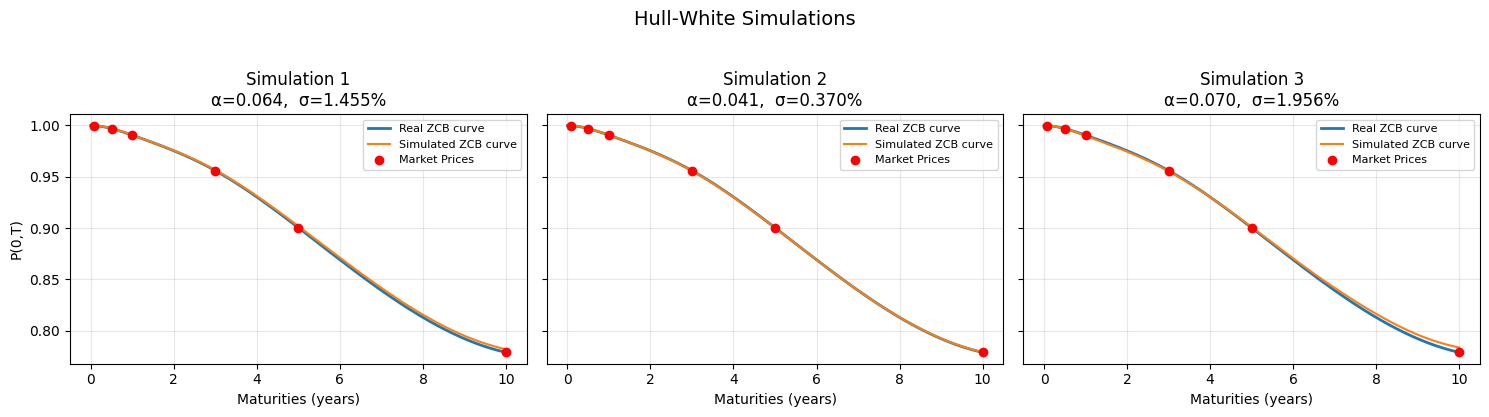

In [15]:
#SIMULATIONS of today zero curve

T = 10
m = 1200
dt = T/m
ts = np.linspace(0, T, m+1)
Nsim = 1000

rng = np.random.default_rng(seed=42)
alpha_range = (0.01, 0.08)
sigma_range = (0.002, 0.02)

alphas = rng.uniform(*alpha_range, size=3)
sigmas = rng.uniform(*sigma_range, size=3)

lnP_interp = interp1d(maturities, -zero_rates*maturities, kind='cubic', fill_value='extrapolate')
P_target = np.exp(lnP_interp(ts))


fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for k, (alpha, sigma, ax) in enumerate(zip(alphas, sigmas, axes), 1):
    theta, fwd = theta_HW(ts, maturities, zero_rates, alpha, sigma)
    r0 = fwd[0]
    r = HW(Nsim, m, r0, theta, alpha, sigma, dt, T)
    DF = discount_factor(r, dt)
    ZCB_simulated_price = DF.mean(axis=0)

    ax.plot(ts, P_target, lw=2, label='Real ZCB curve')
    ax.plot(ts, ZCB_simulated_price,  label='Simulated ZCB curve')
    ax.scatter(maturities, np.exp(-zero_rates*maturities), color='red', zorder=5, label='Market Prices')

    ax.set_title(f'Simulation {k}\nα={alpha:.3f},  σ={sigma:.3%}')
    ax.set_xlabel('Maturities (years)')
    if k == 1:
        ax.set_ylabel('P(0,T)')
    ax.grid(alpha=.3)
    ax.legend(fontsize=8)

plt.suptitle('Hull‑White Simulations', y=1.03, fontsize=14)
plt.tight_layout()
plt.show()

#EXERCISE 3: IRS pricing

In [16]:
#interpolating the discount curve using the given zcb rates and maturities

maturities = np.asarray(maturities, dtype=float)
zero_rates = np.asarray(zero_rates, dtype=float)

def build_discount_curve(maturities, zero_rates, kind='cubic'):
    if maturities.size == 1:
        z = zero_rates[0]
        return lambda t, zc=z: np.exp(-zc * t)
    lnP_interp = interp1d(np.asarray(maturities, float), -np.asarray(zero_rates, float) * np.asarray(maturities, float), kind=kind, fill_value='extrapolate')
    return lambda t: np.exp(lnP_interp(t))

P_mkt = build_discount_curve(maturities, zero_rates)
P_mkt(10) #Just a check



np.float64(0.7788007830714049)

p_mkt is a function. We built build_discount_curve in a way that it returns as output a function that gives the exponential of the interpolated curve. In this way, we can avoid recalculating the interpolation every time and, most importantly, make it more dynamic.

In [17]:
def IRS(P, T, frequency, K, notional=1.0, t_start=0.0, kind='cubic'):

    payment_dates = np.arange(t_start + frequency, T + 1e-12, frequency)
    t_prev = np.insert(payment_dates[:-1], 0, t_start)
    alpha = payment_dates - t_prev

    P_prev    = P(t_prev)
    P_payment = P(payment_dates)
    L = (P_prev / P_payment - 1.0) / alpha
    PV_float = np.sum(alpha * L * P_payment * notional)
    PV_fixed = K * notional * np.sum(alpha * P_payment)
    mtm = PV_float - PV_fixed
    return mtm

In [18]:
K_fair = 2.488 / 100
notional = 1
T = 10
t_val = 0


mtm0 = IRS(P=P_mkt, T=T, frequency=0.5, K=K_fair, notional=notional, t_start=0)
print(f"MtM of the IRS at t=0 (fair rate = {K_fair*100:.3f}%): {mtm0:.10f}")

MtM of the IRS at t=0 (fair rate = 2.488%): -0.0003682877


#Exercise 4: MtM computation across tenors

In [19]:
Nsim=10000
r  = HW(Nsim, m, r0, theta, alpha, sigma, dt, T)

In [20]:
def bond_price_hw(t, T, r_t, a, sigma, zero_curve, forward_rate):
    # 1) B(t,T)
    B = (1 - np.exp(-a * (T - t)))/a
    # 2) A(t,T)
    zT = zero_curve(T)
    zt = zero_curve(t)
    fwd_t = forward_rate(t)
    expo_curve = np.exp(-zT * T) / np.exp(-zt * t)
    expo_hw = np.exp( B * fwd_t - (sigma**2 / (4 * a)) * (1 - np.exp(-2 * a * t)) * B**2 )
    A = expo_curve * expo_hw
    return A * np.exp(-B * r_t)

The price formula for a bond expiring at maturity \(T\):
$$
P(t,T) \;=\; \mathbb{E}^{Q}\!\Bigl[\exp\bigl(\!-\!\!\int_t^T r(s)\,\mathrm{d}s\bigr)\,\big|\,\mathcal{F}_t\Bigr]
$$

Having a solution for the market–implied dynamics of the domestic short‐rate, the following closed‐form can be derived:

$$
P(t,T) \;=\; A(t,T)\,e^{-B(t,T)\,r_d(t)}
$$
where
$$
B(t,T)
\;=\;
\frac{1}{a}\,\bigl(1 - e^{-a\,(T - t)}\bigr),
$$
$$
A(t,T)
\;=\;
\frac{P^{M}(0,T)}{P^{M}(0,t)}
\exp\!\Bigl\{\,B(t,T)\,f^{M}(0,t)\;-\;\frac{\sigma^{2}}{4a}\bigl(1 - e^{-2a\,t}\bigr)\,B(t,T)^{2}\Bigr\}.
$$


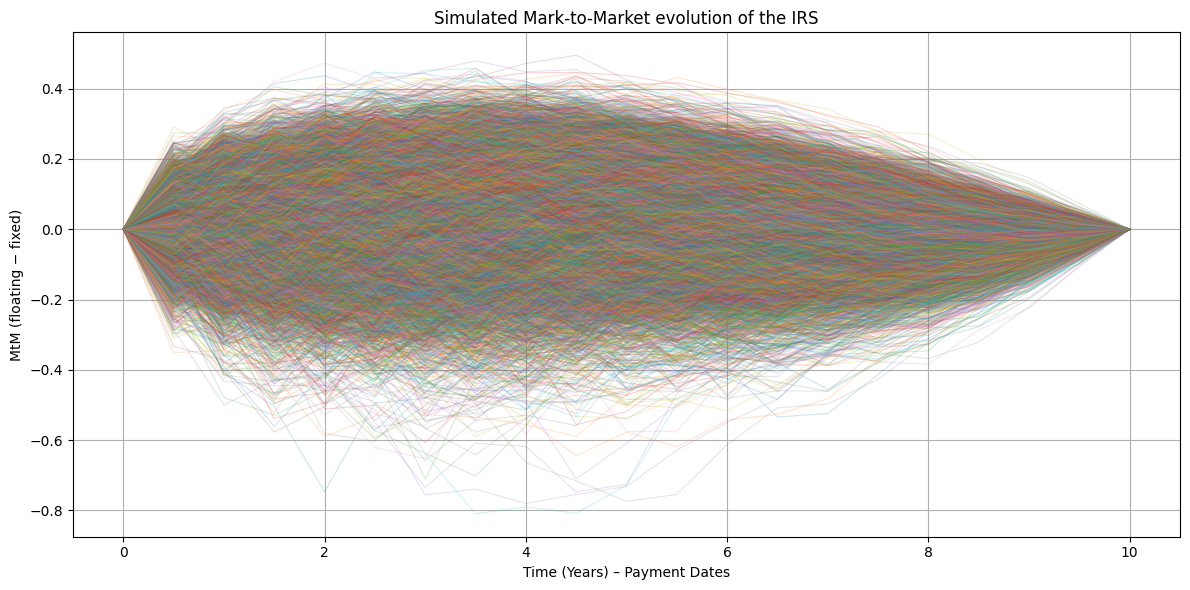

In [21]:
P_mkt = build_discount_curve(maturities, zero_rates)
z_c = interp1d(maturities, zero_rates, kind='cubic', fill_value="extrapolate")
zero_rate = lambda t: z_c(t)
forward_rate = interp1d(ts, fwd, fill_value="extrapolate")

K_fair = 2.488 / 100
notional = 1.0
T = 10.0
delta = 0.5
payment_dates = np.arange(0.0, T + delta/2, delta)
idx_sched = (payment_dates / dt).round().astype(int)
nT = len(payment_dates)
n_paths = r.shape[0]

mtm_matrix = np.zeros((nT, n_paths))

for k in range(1, nT-1):
    t0 = payment_dates[k]
    j0 = idx_sched[k]
    for i in range(n_paths):
        r_u = r[i, j0]
        P_abs = lambda s, t0=t0, ru=r_u: bond_price_hw(
            t0, s, ru, alpha, sigma, zero_rate, forward_rate)
        mtm_matrix[k, i] = IRS(
            P_abs, T, delta, K_fair,
            notional=notional, t_start=t0)

plt.figure(figsize=(12,6))
for i in range(n_paths):
    plt.plot(payment_dates, mtm_matrix[:, i],
             alpha=0.2, linewidth=0.8)
plt.title("Simulated Mark-to-Market evolution of the IRS")
plt.xlabel("Time (Years) – Payment Dates")
plt.ylabel("MtM (floating − fixed)")
plt.grid(True)
plt.tight_layout()
plt.show()

Today’s market zero‐coupon curve \(P_{\rm mkt}(0,t)\) ensures that, at inception, the present values of the fixed and floating legs of an interest‐rate swap exactly offset:
$$
\mathrm{MtM}(0) = 0.
$$

To model the evolution of the swap’s mark‐to‐market (MtM) over time, the short rate \(r(t)\) is simulated under the one‐factor Hull–White model across \(N\) scenarios.  At each payment date \(u\), the following steps are performed:

1. The simulated short‐rate \(r(u)\) is extracted.
2. Zero‐coupon bonds maturing at all future dates \(T\) are re‐priced analytically via the Hull–White formula:
$$
P(u,T)
= A(u,T)\,\exp\bigl(-B(u,T)\,r(u)\bigr),
$$
with
$$
B(u,T) = \frac{1 - e^{-a\,(T-u)}}{a},
\qquad
A(u,T)
= \frac{P^M(0,T)}{P^M(0,u)}
  \exp\!\Bigl\{
    B(u,T)\,f^M(0,u)
    - \frac{\sigma^2}{4a}\bigl(1-e^{-2a\,u}\bigr)\,B(u,T)^2
  \Bigr\}.
$$
3. Floating‐leg cash flows are computed from implied forward rates
$$
L_i = \frac{\frac{P(u,t_{i-1})}{P(u,t_i)} - 1}{\Delta t_i},
$$
and fixed‐leg cash flows are set at the contractual rate \(K\).
4. Both legs are discounted and netted to obtain the MtM at \(u\):
$$
\mathrm{MtM}(u)
= \sum_i \Delta t_i\,L_i\,P(u,t_i)
  \;-\;
  K\sum_i \Delta t_i\,P(u,t_i).
$$

By fixing $\mathrm{MtM}(0)=0$ and $\mathrm{MtM}(T)=0$, the ensemble of simulated MtM paths forms the characteristic “onion” shape, reflecting increasing uncertainty after inception and a collapse to zero at maturity. This methodology leverages today’s curve for model calibration, employs an analytic bond‐pricing kernel for efficiency, and cleanly separates the fixed and floating components of the swap valuation.


#Exercise 5: EE and PFE computation

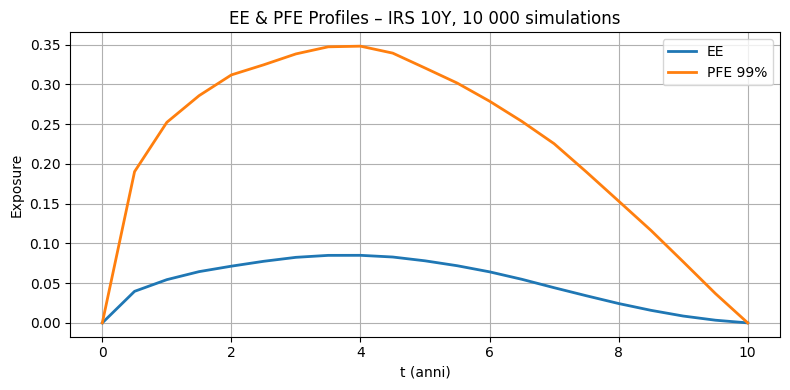

In [22]:
exposure = np.maximum(mtm_matrix, 0)

# EE and PFE across paths
EE  = exposure.mean(axis=1)
PFE = np.percentile(exposure, 99, axis=1)


plt.figure(figsize=(8, 4))
plt.plot(payment_dates, EE,lw=2, label='EE',color='tab:blue')

plt.plot(payment_dates, PFE,lw=2, label='PFE 99%',color='tab:orange')

plt.title('EE & PFE Profiles – IRS 10Y, 10 000 simulations')
plt.xlabel('t (anni)')
plt.ylabel('Exposure')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We recall that the EE at each future point is defined as:
$$EE=\mathbb{E}(MtM,0)^+$$
While the PFE is determined as the 99% Value-at-Risk VaR of the positive MtM distribution across all simulation paths.

#Exercise 6: CVA Computation

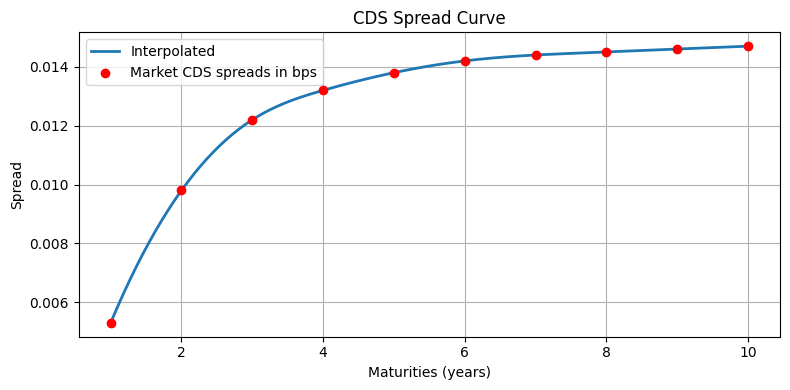

In [23]:
cds_maturities= np.array([1,2,3,4,5,6,7,8,9,10])
cds_spread_bps = np.array([53, 98, 122, 132, 138, 142, 144, 145, 146, 147])

cds_spread = cds_spread_bps / 10000
cds_curve = interp1d(cds_maturities, cds_spread, kind='cubic', fill_value='extrapolate')
t_grid = np.linspace(cds_maturities.min(), cds_maturities.max(), 300)

plt.figure(figsize=(8, 4))
plt.plot(t_grid, cds_curve(t_grid), label='Interpolated', linewidth=2)
plt.scatter(cds_maturities, cds_spread, color='red', marker='o', zorder=5, label='Market CDS spreads in bps')
plt.title('CDS Spread Curve')
plt.xlabel('Maturities (years)')
plt.ylabel('Spread')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [24]:
schedule = np.arange(0, T+1e-12, delta)
LGD  = 0.40
S = np.exp(-cds_curve(schedule)/LGD * schedule)
dPD = S[:-1] - S[1:]
DF = P_mkt(schedule)
EE = exposure.mean(axis=1)

# CVA
CVA = LGD * np.sum(EE[1:] * DF[1:] * dPD)
print("CVA at time 0 is:", CVA)

CVA at time 0 is: 0.006306905944461503


The probability of default between t-1 and t is given by:
$e^{-\lambda(t-1)\cdot(t-1)}-e^{-\lambda(t)\cdot(t)}$
Then, dPD is exactly a vector of this values (between suncle steps).
dPD is a vector of lenght N whose components are the default probability between steps time. EE has lenght N+1 as it takes into account also t0, so that's why we start from 1. The same holds for the discount factors DF.

The formula used is
$$
\mathrm{CVA}
\;:=\;
\mathbb{E}_t\Bigl[\,(1 - R_C)\,\mathbf{1}_{\,t < \tau_C \le \tau}\,D\bigl(t,\tau_C\bigr)\,\mathrm{MtM}\bigl(\tau_C\bigr)^+\Bigr]
$$
recalling that RR = (1-LGD) and by discretizing, the following holds:
$$
\mathrm{CVA}
\;=\;
\mathrm{LGD}\;\sum_{k=1}^{N}
\mathrm{EE}(t_k)\;\mathrm{DF}(t_k)\;\mathrm{dPD}_k,
\quad
dPD_k \;=\; e^{-\frac{s}{LGD}⋅t_{k-1} } \;-\; e^{-\frac{s}{LGD}⋅t_{k} }
$$
Here, $\frac{s}{LGD}$ is the hazard rate, $\lambda(\cdot)$ mentioned before.

Sensitivity:\
The unilateral CVA represents the additional cost associated with a derivative, linked to the counterparty's probability of default. This value adjustment depends directly on the spread curve, which captures the counterparty’s risk profile. Naturally, if the spread curve shifts upward, indicating higher perceived risk, the CVA will also increase accordingly.

In [25]:
cds_spread_shift = cds_spread + 0.01
cds_curve_shift = interp1d(cds_maturities, cds_spread_shift, kind='cubic', fill_value='extrapolate')

# Survival and default probabilities
LGD      = 0.40
schedule = np.arange(0.0, T + 1e-12, delta)
S_shift = np.exp(-cds_curve_shift(schedule) / LGD * schedule)
dPD    = S_shift[:-1] - S_shift[1:]
DF     = P_mkt(schedule)

# Expected exposure
EE     = exposure.mean(axis=1)

# CVA computation
CVA_shift = LGD * np.sum(EE[1:] * DF[1:] * dPD)
print("CVA at time 0 after parallel shift: ", CVA_shift)

CVA at time 0 after parallel shift:  0.009636294331988258


#Exercise 7: FVA computation

In [26]:
fund_spread= 0.004
FVA = np.sum(EE[1:] * DF[1:] * fund_spread*0.5)
print("FVA at time 0: ", FVA)

FVA at time 0:  0.0019186044856878404


the computation of the FVA follows this formula: $$
\mathrm{FVA}
\;=\;
\mathbb{E}^{Q}\Bigl[\int_0^T
P(0,t)\,\bigl(R_{\mathrm{FUNDING}} - r_{f}\bigr)\,\max\bigl(\mathrm{MtM}(t))dt\bigm|\;\mathcal{F}_{0}
\Bigr]
$$

#Exercise 8: EE, PFE, CVA and FVA for a collateralized transaction and MPOR of 10 days

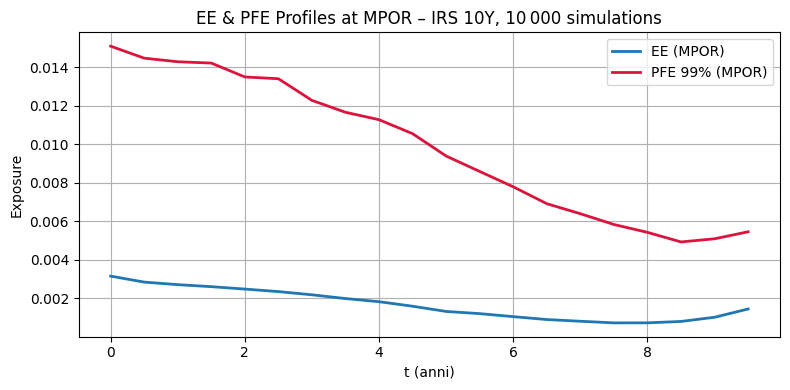

In [30]:
T = 10.0
delta = 0.5
schedule = np.arange(0.0, T + delta/2, delta) #payment dates

MPOR = schedule + 10/252

n_paths = mtm_matrix.shape[1]
final = np.zeros((n_paths, len(schedule)-1))

for i in range(n_paths):
    MtM_d = interp1d(schedule, mtm_matrix[:, i], kind='linear', fill_value='extrapolate')
    final[i, :] = MtM_d(MPOR[:-1]) - MtM_d(schedule[:-1])

# Exposure MPOR
exposure_mpor = np.maximum(final, 0)
EE_mpor  = exposure_mpor.mean(axis=0)
PFE_mpor = np.percentile(exposure_mpor, 99, axis=0)

plt.figure(figsize=(8, 4))
times_mpor = schedule[:-1]
plt.plot(times_mpor, EE_mpor, lw=2, label='EE (MPOR)')
plt.plot(times_mpor, PFE_mpor, lw=2, label='PFE 99% (MPOR)', color='crimson')
plt.title('EE & PFE Profiles at MPOR – IRS 10Y, 10 000 simulations')
plt.xlabel('t (anni)')
plt.ylabel('Exposure')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
schedule = np.arange(0.0, T + delta/2, delta) #payment dates
MPOR = schedule + 10/252

LGD = 0.40
S = np.exp(-cds_curve(schedule[:-1])/LGD * schedule[:-1])
dPD = S[:-1] - S[1:]
DF = P_mkt(schedule[:-1])
EE = exposure_mpor.mean(axis=0)

CVA_mpor = LGD * np.sum(EE_mpor[1:] * DF[1:] * dPD)
print("CVA ", CVA_mpor)

CVA  0.00017076560037623174


For a collateralized contract, the CVA is computed as:
$$
\mathrm{CVA}
:=
\mathbb{E}_t\Bigl[
  (1 - R_C)\,
  \mathbf{1}_{\,t < \tau_C \le \tau}\,
  D\bigl(t,\tau_C\bigr)\,
  \bigl(
    \mathrm{MtM}\bigl(\tau_C + \mathrm{MPOR}\bigr)^+
    \;-\;
    \mathrm{MtM}\bigl(\tau_C\bigr)^+
  \bigr)
\Bigr].
$$

In [ ]:
fund_spread= 0.004
FVA_mpor = np.sum(EE_mpor[1:] * DF[1:] * fund_spread*0.5)
print(f"FVA: {FVA_mpor:.6f}")

FVA: 0.000056


#Exercise 9. 2 Approaches for the FVA of an European DI Put option

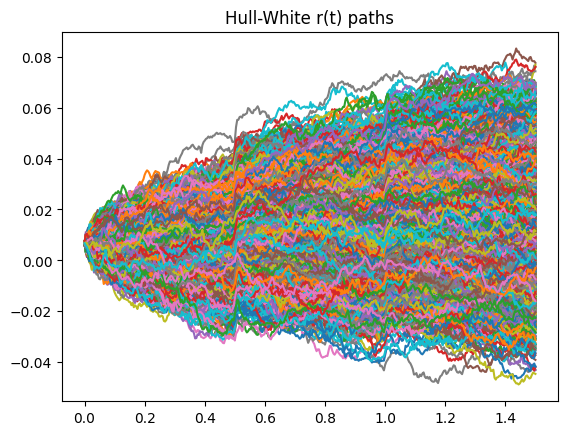

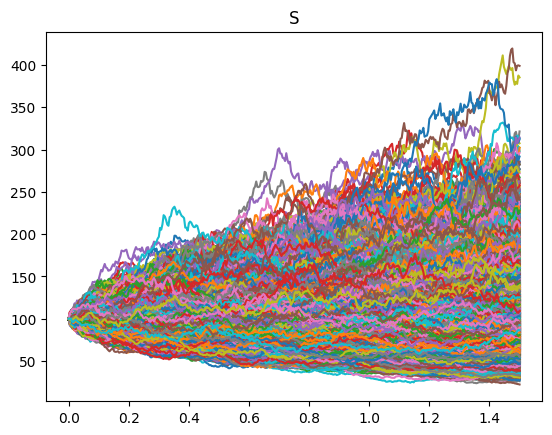

(10000, 376)


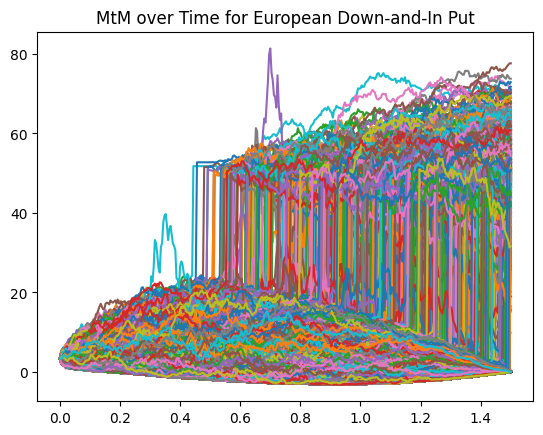

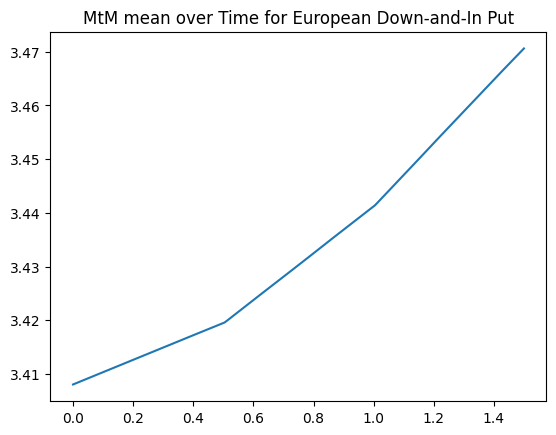

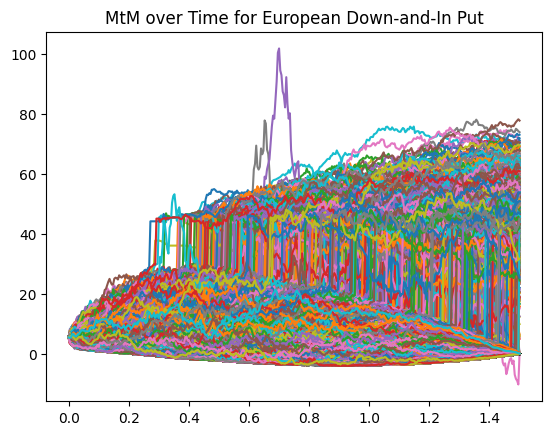

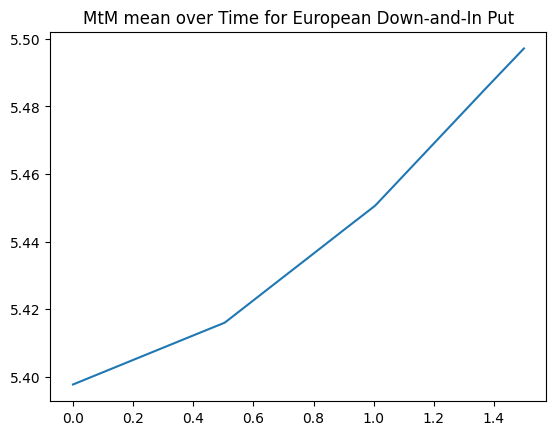

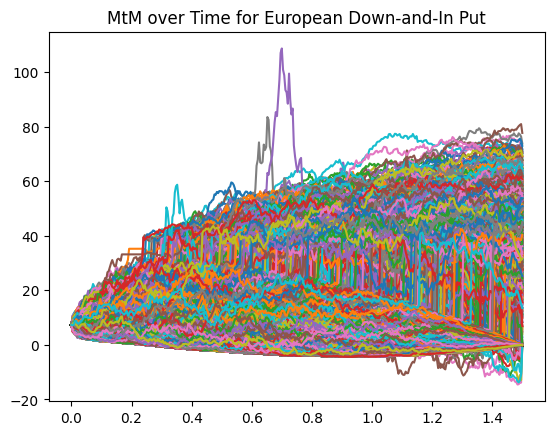

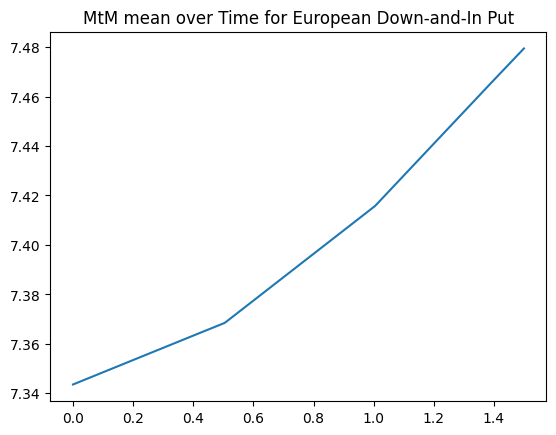

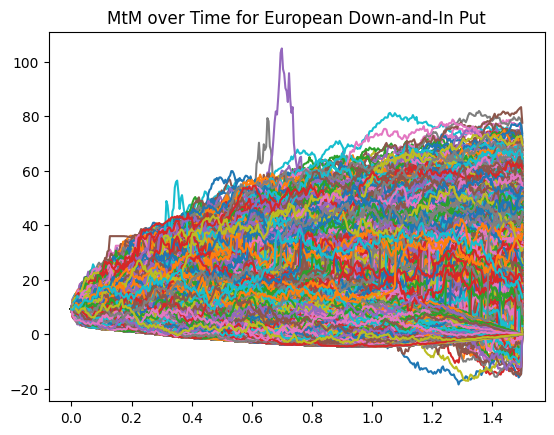

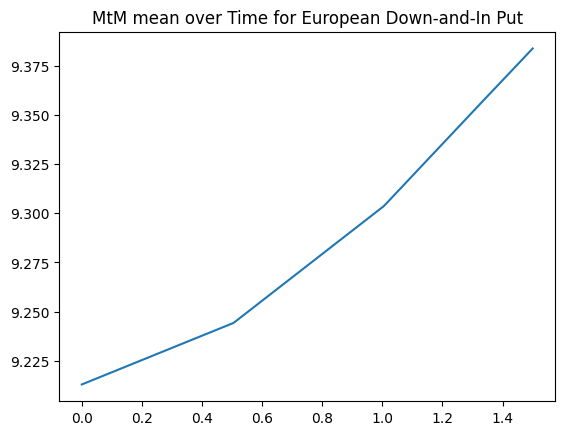

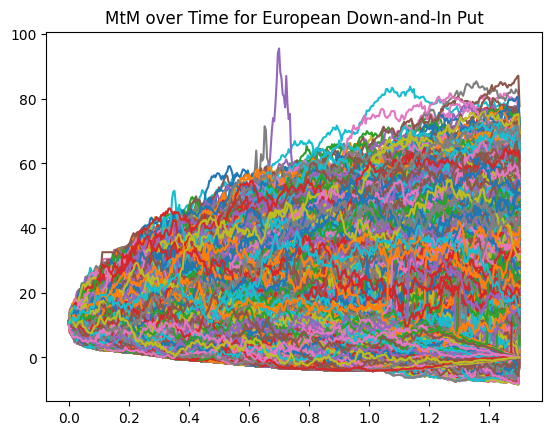

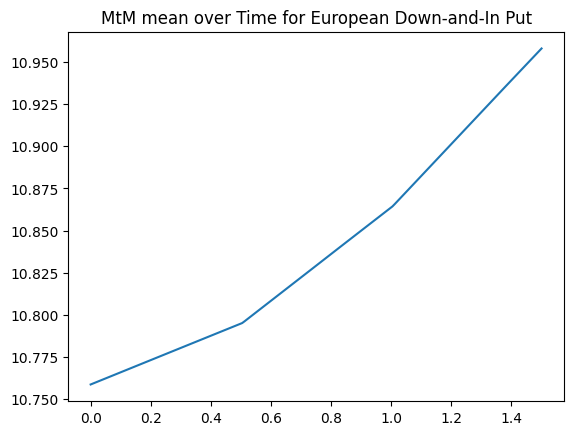

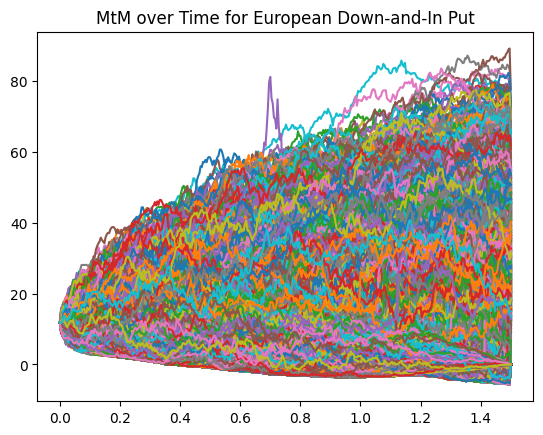

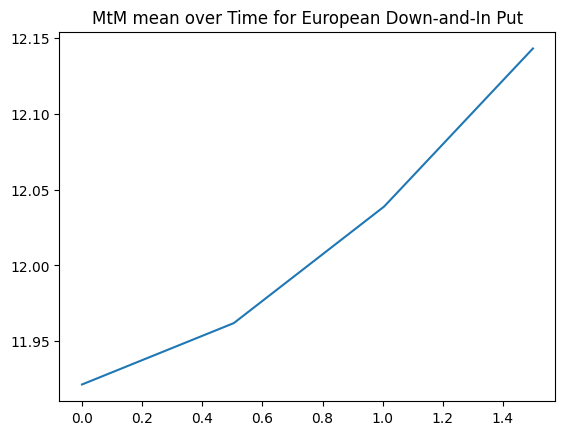

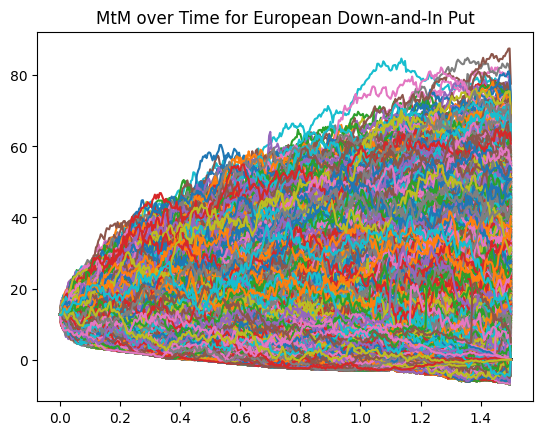

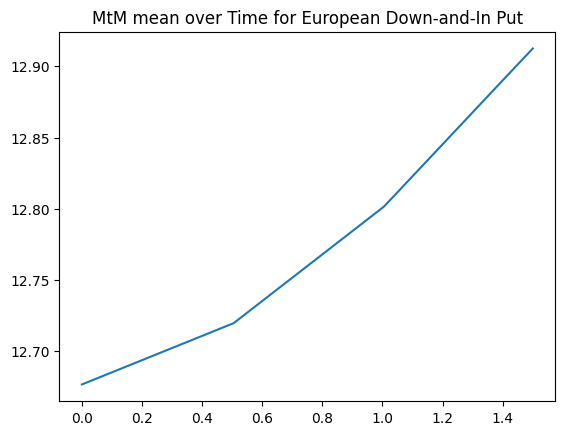

   Barrier       MtM0
0       50   3.408038
1       55   5.397695
2       60   7.343561
3       65   9.212953
4       70  10.758607
5       75  11.921478
6       80  12.676689
        FVA
0  0.022829
1  0.035047
2  0.046533
3  0.057337
4  0.066134
5  0.072668
6  0.076952


In [ ]:
n_scenarios = 10000
T = 1.5
dt=1/250
m_steps = int(T/dt)
S0 = 100
K = 100
vol = 0.3
barriers = np.array([50,55,60,65,70,75,80])
funding_spread = 0.004


maturities = np.array([1/12, 0.5, 1, 3, 5, 10])
zero_rates      = np.array([0.25, 0.6, 0.95, 1.5, 2.1, 2.5]) / 100
alpha = 0.1
sigma_hw = 0.015


ts = np.linspace(0, T, m_steps+1)
theta, fwd = theta_HW(ts, maturities, zero_rates, alpha, sigma_hw, kind='linear')
r0=fwd[0]
r_paths = HW(n_scenarios, m_steps, r0, theta, alpha, sigma_hw, dt, m_steps)

for i in range(int(n_scenarios)):
  plt.plot(ts,r_paths[i,:])
plt.title('Hull-White r(t) paths');
plt.show()

S_paths = np.zeros((n_scenarios, m_steps+1))
S_paths[:, 0] = S0
for j in range(n_scenarios):
    for i in range(m_steps):
        mu = r_paths[j, i]
        z  = np.random.normal()
        S_paths[j, i+1] = S_paths[j, i] * np.exp((mu - 0.5*vol**2)*dt + vol*np.sqrt(dt)*z)

for i in range(int(n_scenarios)):
  plt.plot(ts,S_paths[i,:])
plt.title('S');
plt.show()



DF = np.exp(-np.cumsum(r_paths[:,:m_steps] * dt, axis=1))
DF = np.hstack([np.ones((n_scenarios, 1)), DF])
print(DF.shape)

results = []
FVA_DI =[]
for B in barriers:
    H = np.logical_or.accumulate(S_paths <= B, axis=1)
    V = np.zeros_like(S_paths)
    V[:,-1] = H[:,-1] * np.maximum(K - S_paths[:,-1], 0)
    for i in range(m_steps-1, -1, -1):
        Y   = V[:,i+1] * np.exp(-r_paths[:,i] * dt)
        S_i = S_paths[:,i]
        H_i = H[:,i].astype(float)
        X   = np.column_stack([
            np.ones(n_scenarios),
            S_i,
            S_i**2,
            H_i,
            H_i * S_i,
            H_i * (S_i**2)
        ])
        beta, *_ = np.linalg.lstsq(X, Y, rcond=None)
        V[:,i]   = X.dot(beta)

    for i in range(n_scenarios):
        plt.plot(ts, V[i,:])
    plt.title('MtM over Time for European Down-and-In Put')
    plt.show()

    MtM0 = V[:,0].mean()
    MtMmean = V.mean(axis=0)
    results.append((B, MtM0))
    exposure   = np.maximum(V, 0)
    EE = exposure.mean(axis=0)
    fund_spread= 0.004
    DF_us = P_mkt(ts)
    FVA = np.sum(EE[1:] * DF_us[1:] * fund_spread*dt)
    FVA_DI.append(FVA)

    plt.plot(ts, MtMmean)
    plt.title('MtM mean over Time for European Down-and-In Put')
    plt.show()

df = pd.DataFrame(results, columns=['Barrier', 'MtM0'])
print(df)
fva= pd.DataFrame(FVA_DI, columns=['FVA'])
print(fva)

Least Squares Monte Carlo (LSMC) method of Longstaff and Schwartz (2001) has been applied, which replaces the inner Monte Carlo by a regression onto a set of basis functions.  In general, at each time \(t_i\) we have
$$
\begin{cases}
V\bigl(t_i, S_{t_i}, H_{t_i}\bigr)
=\;
e^{-\,r\,\Delta t}\,
\mathbb{E}^{\mathbb Q}\!\Bigl[
  V\bigl(t_{i+1}, S_{t_{i+1}}, H_{t_{i+1}}\bigr)
  \;\big|\;
  S_{t_i}, H_{t_i}
\Bigr]
\\[8pt]
V\bigl(T, S_{T}, H_{T}\bigr)
=\;H_{T}\,\max\{K - S_{T},\,0\}
\end{cases}
$$

where:
$(S_{t_i})$ is the underlying asset price,  
 $(H_{t_i} = \mathbf1\bigl\{\min_{0\le u\le t_i}S_u \le B\bigr\})$ is the barrier‐activation indicator,   
  $(r)$ is the simulated time‐dependent risk–free rate, and $(\Delta t=t_{i+1}-t_i)$.

LSMC approximates the conditional expectation
$$
\mathbb{E}^\mathbb{Q}\bigl[e^{-r\,\Delta t}\,V(t_{i+1},S_{t_{i+1}},H_{t_{i+1}})\mid S_{t_i},H_{t_i}\bigr]
$$
by projecting the discounted next‐step values onto a finite basis $(\{\phi_k(S,H)\}_{k=1}^K)$.  Defining the regression matrix $(X\in\mathbb{R}^{N\times K})$ with entries $(X_{j,k}=\phi_k\bigl(S_{j,i},H_{j,i}\bigr))$ and the response vector $(Y_j = e^{-r\,\Delta t}V_{j,i+1})$, the LSMC coefficients are
$$
\beta^{(i)}
= \arg\min_{\beta\in\mathbb{R}^K}\sum_{j=1}^N
  \Bigl(Y_j - \sum_{k=1}^K\beta_k\,\phi_k(S_{j,i},H_{j,i})\Bigr)^2
\quad\Longrightarrow\quad
\beta^{(i)} = (X^\top X)^{-1}X^\top Y.
$$
Then one sets
$$
V_{j,i} \;=\;\sum_{k=1}^K \beta_k^{(i)}\,\phi_k\bigl(S_{j,i},H_{j,i}\bigr)
$$
for each scenario \(j\), and proceeds backward in time.

Choice of basis for a Down‐and‐In Put:  
A parsimonious and effective set of basis functions is
\begin{align*}
\phi_1(S,H) &= 1\\
\phi_2(S,H) &= S\\
\phi_3(S,H) &= S^2\\
\phi_4(S,H) &= H\\
\phi_5(S,H) &= H\,S\\
\phi_6(S,H) &= H\,S^2
\end{align*}

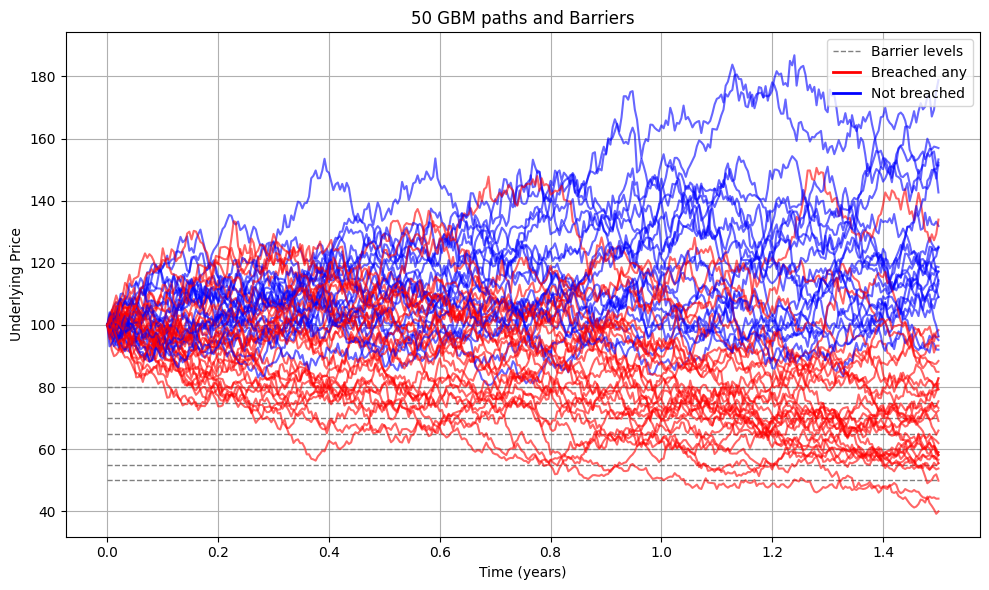

In [ ]:
#Just a Plot
from matplotlib.lines import Line2D
breached_any = np.zeros(Nsim, dtype=bool)
for B in barriers:
    breached_any |= (S_paths <= B).any(axis=1)
N_show = 50
idx_show = np.random.choice(np.arange(Nsim), size=N_show, replace=False)
plt.figure(figsize=(10,6))

for B in barriers:
    plt.hlines(B, ts[0], ts[-1],
               color='gray', linestyle='--', linewidth=1)
for i in idx_show:
    color = 'red' if breached_any[i] else 'blue'
    plt.plot(ts, S_paths[i], color=color, alpha=0.6)

proxy = [
    Line2D([0],[0],color='gray', ls='--', lw=1),
    Line2D([0],[0],color='red', lw=2),
    Line2D([0],[0],color='blue',lw=2),
]
plt.legend(proxy, ['Barrier levels','Breached any','Not breached'],
           loc='upper right')

plt.xlabel('Time (years)')
plt.ylabel('Underlying Price')
plt.title('50 GBM paths and Barriers')
plt.grid(True)
plt.tight_layout()
plt.show()